#### Use the GO (ERGO.jl) code to generate training data for the ERGO.py network

(Use Ctrl+Enter to execute a cell)

### Ensure you run the following before you run this notebook (and have ERGO.jl installed)
```julia
]add Images, Colors, ImageView, DataFrames, CSV, Statistics, LinearAlgebra, Glob, Distributions, JSON, ImageMagick
]add Gtk, DataStructures, CSV, RandomStatsPlots, ProgressMeter
```

Not all of these are dependencies of ERGO, but they are needed for this notebook to help with visualization etc.

In [1]:
using ERGO
using Images, ImageView, DataFrames, CSV, Statistics, LinearAlgebra
import Glob
import Distributions
import JSON
import ImageMagick
using Logging
import Gtk
import DataStructures
import CSV
import Random
import StatsPlots
import ProgressMeter.@showprogress

┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1342
Gtk-Message: 16:59:56.088: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:59:56.088: Failed to load module "pk-gtk-module"
Gtk-Message: 16:59:56.089: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:59:56.089: Failed to load module "pk-gtk-module"
Gtk-Message: 16:59:57.409: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:59:57.409: Failed to load module "pk-gtk-module"
Gtk-Message: 16:59:57.410: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:59:57.410: Failed to load module "pk-gtk-module"
Gtk-Message: 17:00:26.414: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:00:26.414: Failed to load module "pk-gtk-module"
Gtk-Message: 17:00:26.415: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:00:26.415: Failed to load module "pk-gtk-module"
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.j

In [8]:
## These are const, if you change them while this notebook is running behavior will be undefined.
const ROI_PX = 7; # --> ROI is 7*2+1 x 7*2+1 pixels
const PX_NM = 100; # 1 pixel is 100nm
const FRAMESIZE=64; # x/y dim of frame

In [1]:
## Set the path to the data
## This assumes you started in "notebooks", if not set the path manually
currentdir = pwd()
rootpath = joinpath(splitpath(currentdir)[1:end-1]..., "data")
@assert ispath(rootpath)

### Paths

In [6]:
# Download the data from http://bigwww.epfl.ch/smlm/challenge2016/datasets/MT0.N1.HD/Data/data.html
## Change this to where you extracted the frames (~2500tifs)
# For your convenience I've included the data in this repo, but all rights are reserved by original owners (EPFL)
## This assumes you start the notebook in the 'notebooks' folder, if not, alter this path
fpath = joinpath(rootpath, "sequence-MT0.N1.HD-AS-Exp-as-list");
pospath = rootpath
outdir = joinpath(rootpath, "output")
if !ispath(outdir)
    mkpath(outdir)
end
posfile = "activations.csv"
@info "Using $(fpath) as inputdirectory, $(outdir) as output"

┌ Info: Using /home/bcardoen/SFUVault/repositories/ERGO.jl/data/sequence-MT0.N1.HD-AS-Exp-as-list as inputdirectory, /home/bcardoen/SFUVault/repositories/ERGO.jl/data/output as output
└ @ Main In[6]:12


### Test fixed thresholds
This disables GO's automatic threshold detection.

In [9]:
thresholdresult = Dict()
tresholds = [i for i in 0.01:0.005:0.05]
times = Dict()
@showprogress for i in 1:10
    for th in tresholds
        groundtruth_dataframe = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
        range=(1,3)
        train=false
        time = @elapsed results = parseFixedImages(fpath, ROI_PX, PX_NM, groundtruth_dataframe, range, train, th);
        thresholdresult[th] = results
        if haskey(times, th)
            push!(times[th],2500/time)
        else
            times[th] = [2500/time]
        end
    end
end
u_fixed = mean((collect(Iterators.flatten(values(times)))))
s_fixed = std(collect(Iterators.flatten(values(times))))
@info "$(u_fixed) ± $(s_fixed) FPS"

LoadError: AssertionError: N > 0

### Collect the results in a dataframe
This computes accuracy, mcc, etc for the fixed threshold values. You can reuse the same code for GO's autotuning mode.

In [6]:
df = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
resultsdf = DataFrame(th=Float64[],prec=Float64[],rec=Float64[],acc=Float64[],mcc=Float64[],f1=Float64[],fpsm=Float64[], fpss=Float64[], count=Int[])
@showprogress for th in tresholds
    thresholdf = DataFrame(framenr=Int[], tp=Int[], fp=Int[], tn=Int[],fn=Int[], count=Int[])
    for entry in thresholdresult[th]
        TP, FP, TN, FN = zeros(4)
        fnr, centroids = entry
        frame_i = df[df.frame .== fnr,:]
        locs_px = floor.(Int, [frame_i.xnano frame_i.ynano frame_i.znano] ./ PX_NM) .+ 1;
        gtfound = Dict()
        for centroid in centroids
            y_ctr, x_ctr = centroid[1], centroid[2]    
            found = false
            for i in 1:size(frame_i,1)
                x_gt, y_gt, _ = locs_px[i,:]
                if (abs(y_ctr - y_gt) <= ROI_PX) || (abs(x_ctr - x_gt) <= ROI_PX)
                    if haskey(gtfound, i)
                        gtfound[i] += 1
                    else
                        gtfound[i] = 1
                        found = true
                        TP += 1
                    end
                end
            end
            if found == false
                FP += 1
            end
        end
        if length(gtfound) != size(frame_i,1)
            FN += size(frame_i,1) - length(gtfound)
        end
        push!(thresholdf, [fnr, TP, FP, TN, FN, size(centroids, 1)])
    end
    CSV.write(joinpath(outdir,"threshold_$(th).csv"), thresholdf)
    tp = sum(thresholdf.tp)
    fp = sum(thresholdf.fp)
    tn = sum(thresholdf.tn)
    fn = sum(thresholdf.fn)
    cnt = sum(thresholdf.count)
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    f1 = (2*tp)/(2*tp + fp + fn)
    @assert tp >= 0
    @assert fp >= 0
    @assert tn >= 0
    @assert fn >= 0
    mcc_i = mcc(tp, tn, fp, fn)
#     @info "Prec $(prec) Rec $(rec)) Acc $(acc) F1 $(f1) MCC $(mcc_i) for threshold $(th)"
    mfps = mean(times[th])
    sfps = std(times[th])
    push!(resultsdf,[th, prec, rec, acc, mcc_i, f1, mfps, sfps, cnt])
end
CSV.write(joinpath(outdir,"table_tresholding.csv"), resultsdf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


"../data/output/table_tresholding.csv"

### Print the results

In [7]:
resultsdf

,th,prec,rec,acc,mcc,f1,fpsm,fpss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.01,0.0305342,1.0,0.0305342,NaN,0.0592589,1307.71,347.314
2,0.015,0.207635,0.999968,0.207634,-0.00500653,0.343869,1451.12,151.106
3,0.02,0.631011,0.984183,0.624676,-0.0763951,0.768986,1448.16,134.619
4,0.025,0.759049,0.959952,0.73575,-0.0982326,0.84776,1474.58,180.696
5,0.03,0.827437,0.927844,0.777413,-0.111586,0.874769,1469.67,173.44
6,0.035,0.871641,0.885455,0.783316,-0.121256,0.878494,1465.7,150.563
7,0.04,0.904325,0.839302,0.770853,-0.123995,0.870601,1514.35,154.991
8,0.045,0.930011,0.779736,0.736517,-0.124162,0.848269,1468.83,155.927
9,0.05,0.950058,0.702265,0.677263,-0.121941,0.807581,1460.06,204.445


#### Load the Frame
* Load each frame
* Based on the intensity distribution, select ROI to cover regions of high intensity

### Now process with autotuning (no fixed threshold)

In [8]:
# groundtruth_dataframe = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
# Start, stop range for the dynamic threshold, anything below 0.5 is just adding to computational expense 
range=(1,3)
# Set to true if you want to use ground truth (if interested in difference between points captured/omitted)
# if train == true, then load the dataframe (see above)
train=false
groundtruth_dataframe=nothing

time = @elapsed results = parseFixedImages(fpath, ROI_PX, PX_NM, groundtruth_dataframe, range, train, 0);
@info "Processing took $time seconds == $(2500/time) FPS"

┌ Info: Processing took 11.475683218 seconds == 217.85195290844774 FPS
└ @ Main In[8]:10


### Write a dataframe with dataset stats
Compute intensity, score heuristic, threshold etc for each frame.

In [9]:
N = 0
pks = zeros(Float64, 2500)

intensity_data = DataFrame(framenr=Int[], mean=Float64[], std=Float64[],threshold=Float64[],score=Float64[],distance=Float64[])
@showprogress for i in 1:2500
    img, d, score, CC, weightedcentroid, ROIS, modifiedcenter, NegBox, minfiltered, maxfiltered, t = results[i];
    N += size(maxfiltered,1)
    _, _, μ, σ, intens = peaks(img)
    push!(intensity_data, [i, μ, σ, t, score, d])
    pks[i] = size(maxfiltered,1)
end
CSV.write(joinpath(outdir,"intensity.csv"), intensity_data);
@info "\t Density $(mean(pks)) ± $(std(pks))"

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: 	 Density 19.686 ± 9.272895914408604
└ @ Main In[9]:13


In [10]:
intensity_data

,framenr,mean,std,threshold,score,distance
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,0.0120017,0.0032073,1.0,-0.53125,3.5
2,2,0.012136,0.00356637,1.0,4.65217,3.5
3,3,0.0123998,0.0046806,1.0,4.72727,3.5
4,4,0.0123219,0.00432848,1.0,8.46667,3.5
5,5,0.0121153,0.00414979,1.0,9.8125,3.5
6,6,0.0123376,0.00398878,1.0,8.5,3.5
7,7,0.0125723,0.00461208,1.0,7.76923,3.5
8,8,0.0130837,0.00566807,1.0,5.88889,3.5
9,9,0.0126284,0.00581662,1.0,6.5,3.5


### Run a quick benchmark to see if FPS is stable
(@time is not the best way to benchmark, but it'll do for now).

In [11]:
groundtruth_dataframe = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
range=(1,3)
# train=true
train=false
groundtruth_dataframe=nothing
times = []
@showprogress for i in 1:10
    time = @elapsed results = parseFixedImages(fpath, ROI_PX, PX_NM, groundtruth_dataframe, range, train, 0);
    push!(times, 2500/time)
end
@info "$(mean(times)) ± $(std(times)) FPS"

Progress: 100%|█████████████████████████████████████████| Time: 0:01:40
┌ Info: 248.36676131845883 ± 8.358765727076062 FPS
└ @ Main In[11]:11


In [12]:
N = sum(size(results[i][10],1) for i in 1:2500)
@info "Total of $N rois"

┌ Info: Total of 49215 rois
└ @ Main In[12]:2


Frames of interest : 256, 258, 1111, 304, 2000, 1442 for doubles
256 doesn't work with u + 0.5sd

#### Plot intensity distribution / per frame to show high variance

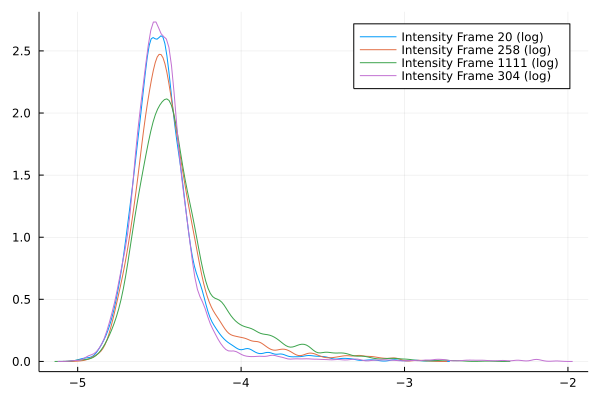

In [13]:
p = nothing
for (fi, FRAME_NR) in enumerate([20, 258, 1111, 304])
    img = results[FRAME_NR][1];
    minint, maxint, μ, σ, intens = peaks(img)
    if fi == 1
        p = StatsPlots.density(log.(intens), label="Intensity Frame $(FRAME_NR) (log)")
    else
        p = StatsPlots.density!(log.(intens), label="Intensity Frame $(FRAME_NR) (log)")
    end
end
display(p)

### Visualize the results per frame
Opens in a new window

In [14]:
FRAME_NR = 2005
img, d, score, CC, weightedcentroid, ROIS, modifiedcenter, NegBox, minfiltered, maxfiltered, t = results[FRAME_NR];
minint, maxint, μ, σens = peaks(img)

df = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
frame_i = df[df.frame .== FRAME_NR,:]
println("\t Have $(size(frame_i)[1]) emissions in frame $FRAME_NR")
locs_px = floor.(Int, [frame_i.xnano frame_i.ynano frame_i.znano] ./ PX_NM) .+ 1;

guidict = imshow(img)
# Plot the ground truth positions
for i in 1:size(frame_i)[1]
    x, y, _ = locs_px[i,:]
    idx2 = annotate!(guidict, AnnotationPoint(x, y, shape='o', size=4, color=RGB(0,1,0)))
end
# Plot the local maxima
for i in maxfiltered
    y, x = i[1], i[2]
    idx2 = annotate!(guidict, AnnotationPoint(x, y, shape='*', size=4, color=RGB(1,1,0)))
end

# Local minima (for debugging)
# for i in minfiltered
#     y, x = i[1], i[2]
#     idx2 = annotate!(guidict, AnnotationPoint(x, y, shape='o', size=4, color=RGB(1,1,0)))
# end

# Plot the centroids of bounding boxes around CC of local maxima
for j in modifiedcenter
    x, y = j[1], j[2]
    idx2 = annotate!(guidict, AnnotationPoint(x, y, shape='+', size=4, color=RGB(0,0,1)))
end

# #  Plot the ROIS of bounding boxes
for (ir,ROI) in enumerate(ROIS)
    lefttop = ROI[3,:]
    rightbottom = ROI[2,:]
    idx5 = annotate!(guidict, AnnotationBox(lefttop[1], lefttop[2], rightbottom[1], rightbottom[2], linewidth=1, color=RGB(1,1,1)))
end

for ROI in NegBox
    lefttop = ROI[1]
    rightbottom = ROI[2]
    idx5 = annotate!(guidict, AnnotationBox(lefttop[1], lefttop[2], rightbottom[1], rightbottom[2], linewidth=1, color=RGB(1,0,0)))
end
# Legend if needed
# idx = annotate!(guidict, AnnotationText(50, 45, "o = Ground Truth [x y] of emitter", color=RGB(0,1,0), fontsize=1));
# idx = annotate!(guidict, AnnotationText(50, 40, "--- = Noise ROI", color=RGB(1,0,0), fontsize=1));
# idx = annotate!(guidict, AnnotationText(50, 35, "--- = ROI", color=RGB(1,1,1), fontsize=1));
# idx = annotate!(guidict, AnnotationText(50, 60, "--- = Connected Component", color=RGB(1,0,1), fontsize=1));
# idx = annotate!(guidict, AnnotationText(50, 50, "* = Local Maxima", color=RGB(1,1,0), fontsize=1));
# idx = annotate!(guidict, AnnotationText(50, 55, "+ = Intensity Weighted Centroid of ROI", color=RGB(0,0,1), fontsize=1));

# Plot the graph
SM = size(maxfiltered, 1)
for (mc,cc) in zip(modifiedcenter, CC)
    if size(cc)[1] > 1
        points = []
        for c in cc
            if c > SM
                i = c-SM
                push!(points, locs_px[i,:])
            else
                i = c
                pt = maxfiltered[i]
                push!(points, [pt[2], pt[1]])
            end
        end
        for (i,p) in enumerate(points)
            annotate!(guidict, AnnotationLine(p[1], p[2], mc[1], mc[2], linewidth=1, color=RGB(1,0,1)))
        end
    end
end

	 Have 15 emissions in frame 2005


#### Save to file
* Save ROI
* Save GT
* Save x,y lower left offset

This function will write the training data from ER

In [15]:
time = @elapsed tdata =  writeTrainingData(results, joinpath(pospath, posfile), outdir, ROI_PX, PX_NM)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


12.241303802

## Compute CSV tables for training

In [16]:
outdf = DataFrame(framenr=Int[], roinr=Int[], mx=Int[], my=Int[],count=Int[])
for (frame_nr, values) in tdata["data"]
    _, _, _, _, _, ROIS, _, NegBox, _, _, t = results[frame_nr]
    for (roi_nr, rvalues) in values
        mx, my = 0, 0
        if roi_nr == "missed"
            continue
        end
        if roi_nr == -1
            roi_nr = 0
            x1, x2 = NegBox[1][1][1], NegBox[1][2][1]
            y1, y2 = NegBox[1][1][2], NegBox[1][2][2]
            mx = min(x1, x2)
            my = min(y1, y2)
        else
            x1, x2 = ROIS[roi_nr][1,1], ROIS[roi_nr][2,1]
            y1, y2 = ROIS[roi_nr][1,2], ROIS[roi_nr][2,2]
            mx = min(x1, x2)
            my = min(y1, y2)
        end
        N = size(rvalues["roi"],1)
        push!(outdf, [frame_nr, roi_nr, mx, my, N])
    end
end

In [17]:
evaldf = DataFrame(framenr=Int[], tp=Float64[], fp=Float64[], tn=Float64[],fn=Float64[],count=Int[])
for (frame_nr, values) in tdata["data"]
    tp, fp, tn, fn, count = 0, 0, 0, 0, 0
    for (roi_nr, rvalues) in values
        if roi_nr == "missed"
            for missed in rvalues
                if missed == []
                    fn += 1
                end
            end
            continue
        end
        if roi_nr == -1
            N = size(rvalues["roi"],1)
            if N == 0
                tn += 1
            else
                fn += 1
            end
        else
            N = size(rvalues["roi"],1)
            if N > 0
                tp += 1
            else
                fp += 1
            end
        end
        count += 1
    end
    push!(evaldf, [frame_nr, tp, fp, tn, fn, count])
end
CSV.write(joinpath(outdir,"ours_roi.csv"), evaldf)

"../data/output/ours_roi.csv"

### Report results

In [18]:
tp = sum(evaldf.tp)
fp = sum(evaldf.fp)
tn = sum(evaldf.tn)
fn = sum(evaldf.fn)
cnt = sum(evaldf.count)
prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = (tp+tn)/(tp+fn+fp+tn)
f1 = (2*tp)/(2*tp + fp + fn)
mcc_i = mcc(tp, tn, fp, fn)
@info "Prec $(prec) Rec $(rec)) Acc $(acc) F1 $(f1) MCC $(mcc_i) $cnt"

┌ Info: Prec 0.9220016773832821 Rec 0.9310466511398122) Acc 0.8729127451575688 F1 0.9265020894054852 MCC 0.45770455751592903 31116
└ @ Main In[18]:11


In [19]:
println(outdf)

31116×5 DataFrame
   Row │ framenr  roinr  mx     my     count 
       │ Int64    Int64  Int64  Int64  Int64 
───────┼─────────────────────────────────────
     1 │    1144      5     29      4      2
     2 │    1144     12     44     20      4
     3 │    1144      8     26      1      2
     4 │    1144      1      1      8      1
     5 │    1144      6     24      8      2
     6 │    1144     11     43     14      5
     7 │    1144      0     29     48      0
     8 │    1144      9     26     17      2
     9 │    1144      3      9     47      3
    10 │    1144      7     25     22      2
    11 │    1144      4     10     41      2
    12 │    1144     13     50     24      3
    13 │    1144      2      4     49      4
    14 │    1144     10     30     21      3
    15 │    2108      5     16     23      2
    16 │    2108     12     25     23      3
    17 │    2108      8     20     21      3
    18 │    2108      1      9     44      3
    19 │    2108      6     17    

  2782 │    1070      4     26     22      5
  2783 │    1070      6     50     23      4
  2784 │    1070      7     50     22      4
  2785 │    1070      2     17     29      1
  2786 │    1070      0      1     42      0
  2787 │    1070      3     20     16      4
  2788 │    1070      1     12     12      3
  2789 │    2474      5     22     18      4
  2790 │    2474     12     36     20      1
  2791 │    2474      8     28      3      6
  2792 │    2474      1      2     10      3
  2793 │    2474      6     22     25      4
  2794 │    2474     11     33      9      5
  2795 │    2474      0     30     45      0
  2796 │    2474      9     26     17      2
  2797 │    2474     14     50     27      1
  2798 │    2474      3     10     41      1
  2799 │    2474      7     23     11      5
  2800 │    2474      4     17     25      4
  2801 │    2474     13     41     18      1
  2802 │    2474      2      8     12      2
  2803 │    2474     10     29     12      3
  2804 │  

  4176 │    1362     10     22     23      2
  4177 │     143      5     13     50      2
  4178 │     143     12     31     18      1
  4179 │     143      8     21     38      0
  4180 │     143      1      4     50      2
  4181 │     143      6     18     27      3
  4182 │     143     11     30     24      2
  4183 │     143      0      1      7      0
  4184 │     143      9     22     25      4
  4185 │     143     14     43     19      1
  4186 │     143      3      9     50      2
  4187 │     143      7     20     30      3
  4188 │     143      4     11     30      1
  4189 │     143     13     36     18      2
  4190 │     143      2      4     50      2
  4191 │     143     10     23     17      1
  4192 │    1326      5     29     16      1
  4193 │    1326      4     13     32      2
  4194 │    1326      6     29     36      0
  4195 │    1326      7     38     18      2
  4196 │    1326      2      8     44      1
  4197 │    1326      0     47     49      0
  4198 │  

  5570 │     645      2     14     29      1
  5571 │     645     10     25     26      2
  5572 │    2087      5     19     22      6
  5573 │    2087      8     25      8      2
  5574 │    2087      1      5     10      2
  5575 │    2087      6     22     16      7
  5576 │    2087      0     30     49      0
  5577 │    2087      9     29      8      2
  5578 │    2087      3     12     37      2
  5579 │    2087      7     21     30      1
  5580 │    2087      4     14     16      3
  5581 │    2087      2     11     14      3
  5582 │    2087     10     50     22      3
  5583 │    2219      5     10     37      2
  5584 │    2219      8     32     18      2
  5585 │    2219      1      5     50      2
  5586 │    2219      6     10     50      2
  5587 │    2219      0     31     47      0
  5588 │    2219      9     37     23      2
  5589 │    2219      3      9     16      2
  5590 │    2219      7     15     16      2
  5591 │    2219      4      9     43      3
  5592 │  

  6965 │     903      1      1     30      0
  6966 │     903     19     41     19      2
  6967 │     903     22     50     25      3
  6968 │     903      6     14      1      0
  6969 │     903     11     18     21      2
  6970 │     903      0     29     47      0
  6971 │     903      9     16     14      1
  6972 │     903     14     25      6      0
  6973 │     903      3      7      2      0
  6974 │     903      7     15      1      0
  6975 │     903      4      7     21      0
  6976 │     903     13     19     27      1
  6977 │     903     15     28     14      1
  6978 │     903      2      6     11      2
  6979 │     903     10     16     24      2
  6980 │     903     18     40     15      1
  6981 │     903     21     48     22      3
  6982 │     318      5     15     16      1
  6983 │     318     12     30      1      2
  6984 │     318      8     21     25      5
  6985 │     318      1      1      8      1
  6986 │     318      6     15     30      5
  6987 │  

  8359 │     734      0     30     49      0
  8360 │     734      9     15     28      1
  8361 │     734     14     26     27      1
  8362 │     734      3      9     50      2
  8363 │     734      7     12     19      2
  8364 │     734      4      8     17      1
  8365 │     734     13     20     26      2
  8366 │     734     15     32     17      2
  8367 │     734      2      2     50      2
  8368 │     734     10     17     10      1
  8369 │     734     18     41     20      3
  8370 │    2312      5     26     12      4
  8371 │    2312      4     27      7      3
  8372 │    2312      6     27     19      6
  8373 │    2312      7     38     17      1
  8374 │    2312      2     21     25      5
  8375 │    2312      0      1     19      0
  8376 │    2312      8     50     31      3
  8377 │    2312      3     22     17      6
  8378 │    2312      1      7     50      2
  8379 │      67      5      6     15      2
  8380 │      67     16     50     30      1
  8381 │  

Excessive output truncated after 524288 bytes.

In [20]:
CSV.write(joinpath(outdir,"density.csv"), outdf)

"../data/output/density.csv"

In [21]:
totalmissed = 0
framedensity = []
intensity = []
for (frame_nr, values) in tdata["data"]
    if !isa(frame_nr, String)
        missed = values["missed"]
        for (i,m) in enumerate(missed)
            N = size(m,1)
            if N == 0
                totalmissed += 1
                frame_i = df[df.frame .== frame_nr,:]
                push!(intensity, frame_i[i, 6])
            end
            push!(framedensity, N)
        end
    end
    push!(framedensity, 0)
end

In [22]:
df = CSV.File(joinpath(pospath, posfile)) |> DataFrame;
NGT = size(df,1)
MGT = totalmissed
println("\t Have $NGT GT points, with $MGT not observed = $(MGT / NGT * 100) %, best Jaccard = $(100-(MGT / NGT * 100))")
println("\t μ intensity of missed = $(mean(intensity)), vs overall μ = $(mean(df[:,6]))")

	 Have 31612 GT points, with 1822 not observed = 5.763634063014045 %, best Jaccard = 94.23636593698595
	 μ intensity of missed = 1479.0589012074668, vs overall μ = 4621.4776545299255


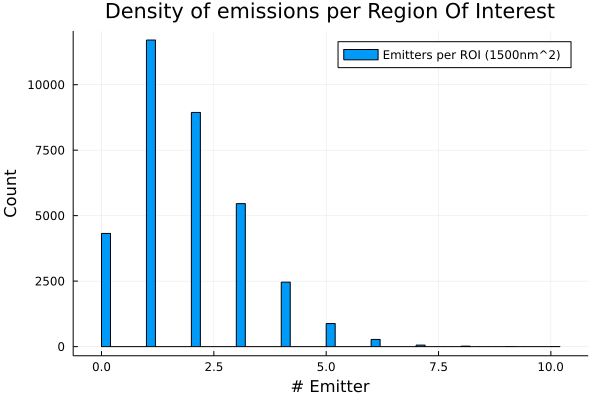

In [23]:
using Plots
import GR
gr()
Plots.histogram(framedensity, bins=:scott, label="Emitters per ROI (1500nm^2)", xlabel="# Emitter", ylabel="Count", title="Density of emissions per Region Of Interest")

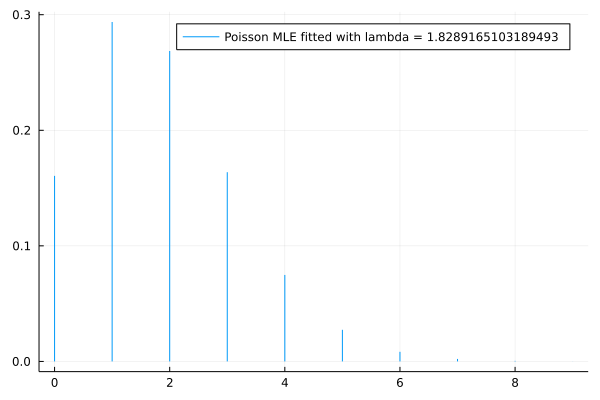

In [24]:
dt = Array{Int64}(undef, size(framedensity,1))
for (i,fd) in enumerate(framedensity)
    dt[i] = fd
end
pfit = Distributions.fit_mle(Distributions.Poisson, dt)
StatsPlots.plot(pfit, label="Poisson MLE fitted with lambda = $(pfit.λ)")

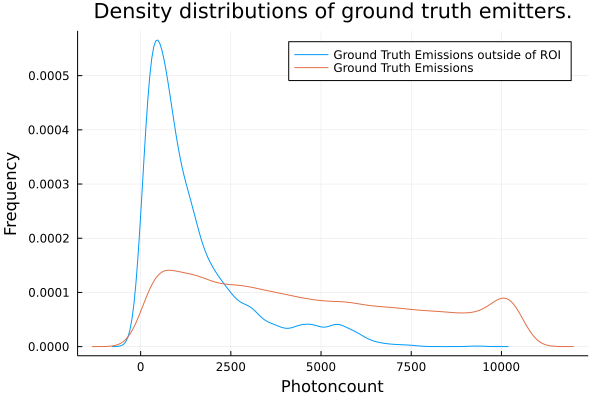

In [25]:
StatsPlots.density(intensity, label="Ground Truth Emissions outside of ROI")
StatsPlots.density!(df[:,6], label="Ground Truth Emissions ", xlabel="Photoncount", ylabel="Frequency", title="Density distributions of ground truth emitters.")

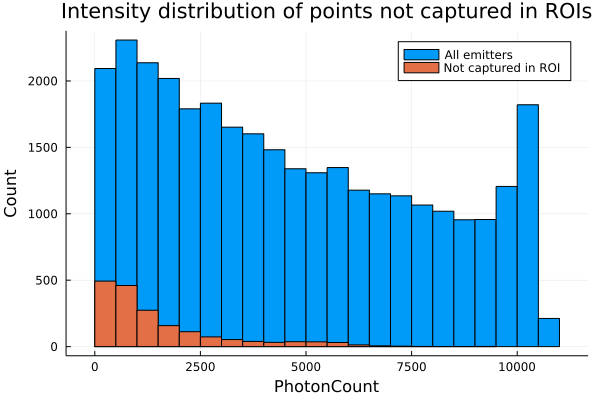

In [26]:
Plots.histogram(df[:,6], bins=:scott, label="All emitters")
Plots.histogram!(intensity, bins=:scott, label="Not captured in ROI", ylabel="Count", xlabel="PhotonCount", title="Intensity distribution of points not captured in ROIs")

#### Look at information encoded in time
* Inter Frame Correlation (is there a signal?)
* What if we scramble frames?
* What is the intensity mean/std over time?

In [27]:
tiffiles = Glob.glob("[0-9]*.tif",fpath)
images = ERGO.loadimages(tiffiles);

### Black = 0, white =1
* Frame correlation returns a number [0,1], 1 for identical frames, 0 for opposite frames.
* Look at subsequent frames
* Look at randomized frames
* Look at where the correlation breaks down

### For a single step (frame i vs frame i+1) correlation is quite high
In the below striping pattern you can observe long bands of correlated (white) frames, interrupted by bands of non correlated frames (if density/emmission suddenly change)

In [28]:
fcorss = ERGO.framecorrelation(images, false, 0, 1)

In [29]:
corrdf = DataFrame(framenr=Int[], dist=Int[], corr=Float64[])
for (frame_nr,corr) in enumerate(fcorss)    
    push!(corrdf, [frame_nr, 1, corr])
end
corrdf
CSV.write(joinpath(outdir,"correlation_ft.csv"), corrdf)

"../data/output/correlation_ft.csv"

### For longer step sizes this starts to decrease. Despite this, observe the highly correlated frames

In [30]:
fcorss = ERGO.framecorrelation(images, false, 0, 2)

In [31]:
fcorss = ERGO.framecorrelation(images, false, 0, 3)

### Let's look at random frame correlation (mean distance = +- 800)

In [32]:
fcorss = ERGO.framecorrelation(images, true, 0, 1)

┌ Info: Using seed 0 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241


In [33]:
using Plots
randomcorrs = DataStructures.OrderedDict()
for seed in [1,2,3,5,7,11,13,17,19,23,31,33]
    fcorss = ERGO.framecorrelation(images, true, seed, 1)
    randomcorrs[seed] = fcorss
end

seqcorrs = DataStructures.OrderedDict()
for i in 0:32
    step = i
    seqcorrs[step] = ERGO.framecorrelation(images, false, 0, step)
end

xs = [k for k in keys(seqcorrs)]
μs = [convert(Float64, Statistics.mean(c)) for c in values(seqcorrs)]
σs = [convert(Float64, Statistics.std(c)) for c in values(seqcorrs)]

plot(xs,μs,grid=true,ribbon=σs,fillalpha=.2)

rxs = [k for k in keys(randomcorrs)]
rμs = [convert(Float64, Statistics.mean(c)) for c in values(randomcorrs)]
rσs = [convert(Float64, Statistics.std(c)) for c in values(randomcorrs)]

plot!(rxs,rμs,grid=true,ribbon=rσs,fillalpha=.2)
savefig("correlation.svg")

┌ Info: Using seed 1 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 2 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 3 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 5 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 7 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 11 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 13 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 17 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 19 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 23 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Inf

┌ Info: Using seed 1 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 2 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 3 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 5 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 7 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 11 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 13 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 17 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 19 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Info: Using seed 23 for RNG
└ @ ERGO /home/bcardoen/SFUVault/repositories/ERGO.jl/src/ERGO.jl:241
┌ Inf

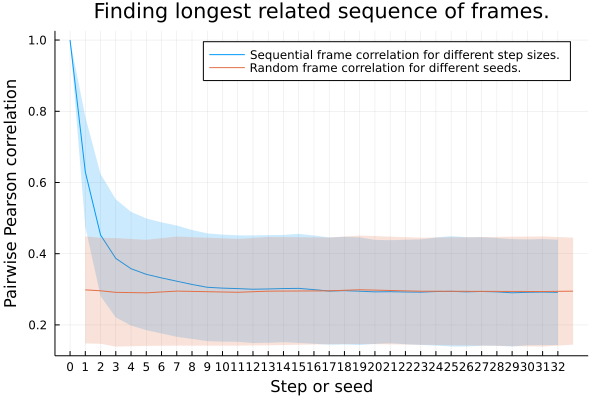

In [34]:
using Plots
randomcorrs = DataStructures.OrderedDict()
for seed in [1,2,3,5,7,11,13,17,19,23,31,33]
    fcorss = ERGO.framecorrelation(images, true, seed, 1)
    randomcorrs[seed] = fcorss
end

seqcorrs = DataStructures.OrderedDict()
for i in 0:32
    step = i
    seqcorrs[step] = ERGO.framecorrelation(images, false, 0, step)
end

xs = [k for k in keys(seqcorrs)]
μs = [convert(Float64, Statistics.mean(c)) for c in values(seqcorrs)]
σs = [convert(Float64, Statistics.std(c)) for c in values(seqcorrs)]

plot(xs,μs,grid=true,ribbon=σs,fillalpha=.2, label="Sequential frame correlation for different step sizes.",yaxis="Pairwise Pearson correlation", xaxis="Step or seed")

rxs = [k for k in keys(randomcorrs)]
rμs = [convert(Float64, Statistics.mean(c)) for c in values(randomcorrs)]
rσs = [convert(Float64, Statistics.std(c)) for c in values(randomcorrs)]

plot!(rxs,rμs,grid=true,ribbon=rσs,fillalpha=.2, label="Random frame correlation for different seeds.", xticks = 0:1:32, title="Finding longest related sequence of frames.")

In [40]:
Testbegin = 2257
Testend = 2500

2500